# Homework 4
### 20180594 이정훈

## Module Import

In [1]:
import pandas_datareader as wb, pandas as pd, datetime, matplotlib.pyplot as plt, numpy as np
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
data = pd.read_excel('Boston.xlsx', index_col = 0)

In [3]:
data = data.astype('float')

<br>
<span style="font-size:120%">
    Assume the local linear trend model for Boston's monthly temperature data uploaded in the class website. <br>
    Plot the Kalman filter and smoother for the data

In [4]:
from scipy.stats import norm
import statsmodels.api as sm

class LocalLinearTrend(sm.tsa.statespace.MLEModel):
    def __init__(self, endog):

        k_states = k_posdef = 2

        super(LocalLinearTrend, self).__init__(
            endog, k_states = k_states, k_posdef = k_posdef,
            initialization = 'approximate_diffuse',
            loglikelihood_burn=k_states
        )

        self.ssm['design'] = np.array([1, 0])
        self.ssm['transition'] = np.array([[1, 1], [0, 1]])
        self.ssm['selection'] = np.eye(k_states)

        self._state_cov_idx = ('state_cov',) + np.diag_indices(k_posdef)

    @property
    def param_names(self):
        return ['sigma2.measurement', 'sigma2.level', 'sigma2.trend']

    @property
    def start_params(self):
        return [np.std(self.endog)] * 3

    def transform_params(self, unconstrained):
        return unconstrained ** 2

    def untransform_params(self, constrained):
        return constrained ** 0.5

    def update(self, params, *args, **kwargs):
        params = super(LocalLinearTrend, self).update(params, *args, **kwargs)

        self.ssm['obs_cov', 0, 0] = params[0]

        self.ssm[self._state_cov_idx] = params[1:]

In [5]:
data.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01',
               '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', name='DATE', length=474, freq=None)

In [6]:
matrix = data.pct_change(periods = 12).dropna()

In [7]:
mod = LocalLinearTrend(data['TAVG'])

/Users/tommylee/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [8]:
result = mod.fit(disp = False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                   TAVG   No. Observations:                  474
Model:               LocalLinearTrend   Log Likelihood               -1327.934
Date:                Thu, 10 Nov 2022   AIC                           2661.867
Time:                        00:46:05   BIC                           2674.338
Sample:                    01-01-1980   HQIC                          2666.773
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
sigma2.measurement     0.6657      0.825      0.807      0.420      -0.951       2.282
sigma2.level        6.565e-10      3.262   2.01e-10      1.000      -6.394       6.394
sigma2.trend          12.6991      2.231      5.692      0.000       8.326      17.072
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                69.58
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.73
Prob(H) (two-sided):                  0.46   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
predict = result.get_prediction()

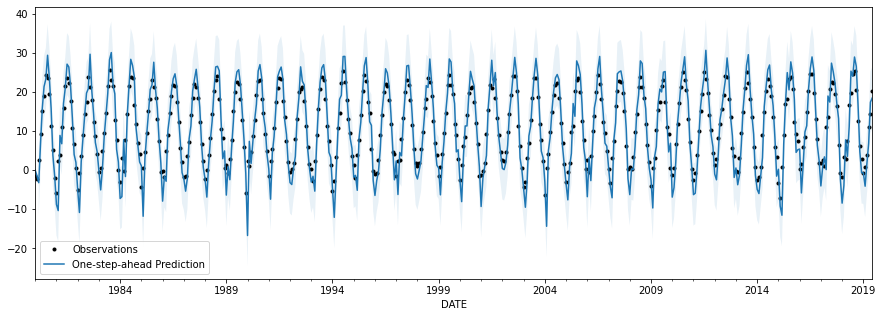

In [10]:
fig, ax = plt.subplots(figsize=(15,5))

data['TAVG'].plot(ax = ax, style = 'k.', label = 'Observations')
predict.predicted_mean.plot(ax = ax, label = 'One-step-ahead Prediction')
predict_ci = predict.conf_int(alpha = 0.05)
predict_index = np.arange(len(predict_ci)) + 120
ax.fill_between(predict_index[2:], predict_ci.iloc[2:, 0], predict_ci.iloc[2:, 1], alpha = 0.1)

legend = ax.legend(loc = 'lower left');